# Empirical Analysis 

This notebook runs the empirical analysis part

In [248]:
# Required libraries
# Required libraries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from pathlib import Path
import sys
import os 
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import datetime
import zipfile 
from timeit import default_timer as timer
import sqlalchemy as db
# Paths
sys.path.append(os.path.join(Path(os.getcwd()).parent))  
sys.path.append(os.path.join(os.path.join(Path(os.getcwd()).parent), 'modules'))
data_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'data')
results_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'results')
from helper_functions import *
from univariate_tests import *

# create connection to sqlite database
db_path = os.path.join(data_path, 'database.db')
db_engine = db.create_engine('sqlite:///' + db_path)

params = {
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [241]:
# import returns & plot returns 
returns = pd.read_sql("select * from returns", db_engine)
returns.DT = pd.to_datetime(returns.DT)
returns.set_index('DT', inplace=True)
returns = returns[['EEM', 'SPY', 'EZU']]
returns_test = returns[returns.index.month >=12]
simple_returns = returns_test.apply(lambda x: np.exp(x) - 1)
x_values = np.array([d.strftime('%Y-%m-%d') for d in np.unique([d.date() for d in simple_returns.index])])

# Global Minimum Variance Portfolios

In [242]:
dcc11_weights = pd.read_excel(os.path.join(data_path, 'dcc11_weights.xlsx'))
dcc_opt_a_weights = pd.read_excel(os.path.join(data_path, 'dcc_opt_a_weights.xlsx'))
dcc_opt_weights = pd.read_excel(os.path.join(data_path, 'dcc_opt_weights.xlsx'))
simulation_1_weights = pd.read_excel(os.path.join(data_path, 'simulation_predictions1_weights.xlsx'))
simulation_2_weights = pd.read_excel(os.path.join(data_path, 'simulation_predictions2_weights.xlsx'))

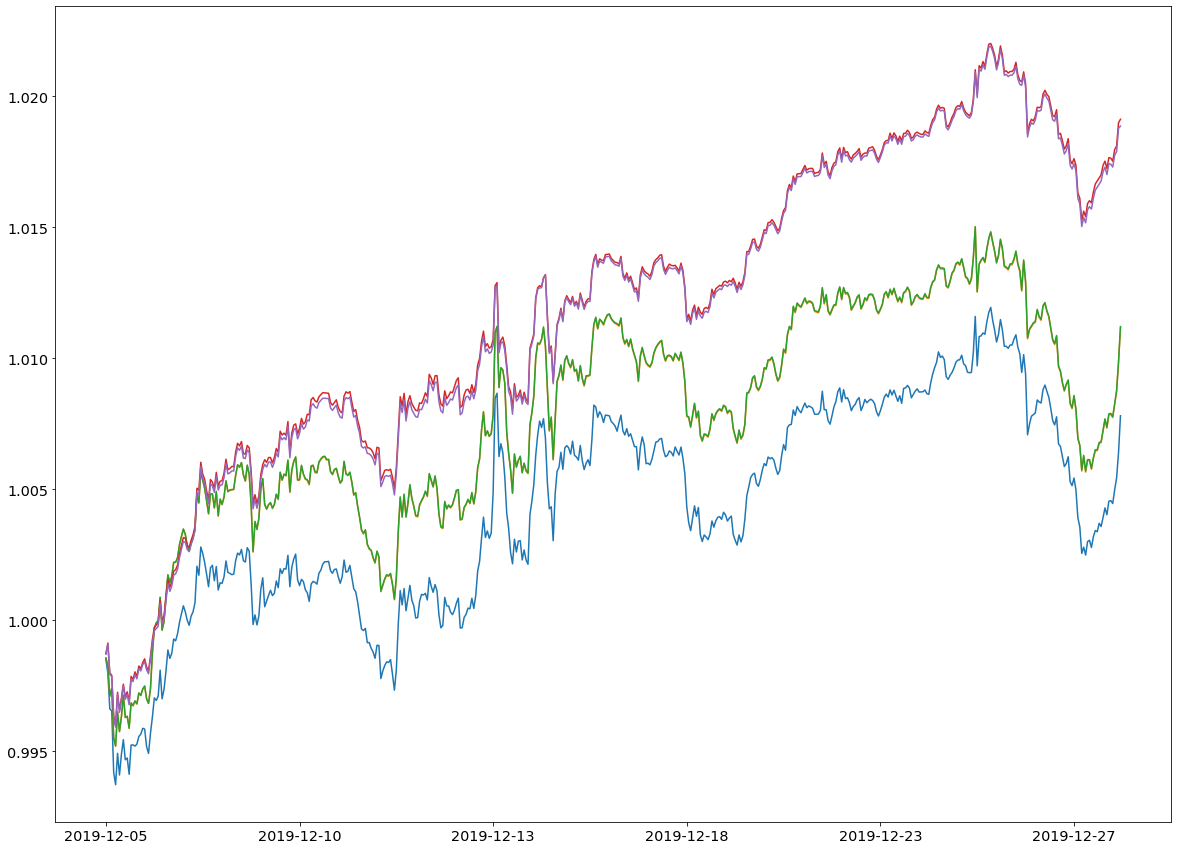

In [244]:
fig,ax = plt.subplots(1,1,figsize=(20,15))
plt.plot(np.cumprod(1 + np.multiply(dcc11_weights.values, simple_returns.values).sum(axis=1)), label='dcc11')
plt.plot(np.cumprod(1 + np.multiply(dcc_opt_weights.values, simple_returns.values).sum(axis=1)), label='dcc_opt')
plt.plot(np.cumprod(1 + np.multiply(dcc_opt_a_weights.values, simple_returns.values).sum(axis=1)), label='dcc_opt_a')
plt.plot(np.cumprod(1 + np.multiply(simulation_1_weights.values, simple_returns.values).sum(axis=1)), label='simulation_1')
plt.plot(np.cumprod(1 + np.multiply(simulation_2_weights.values, simple_returns.values).sum(axis=1)), label='simulation_2')
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(x_values[[0,3,6,9,12,15,18,-1]])
#plt.legend()
plt.savefig(os.path.join(results_path, 'gmv_plots.png'), dpi=400, facecolor='aliceblue',edgecolor='k',bbox_inches='tight')
plt.show()

# Plots

In [245]:
dcc11_results = pd.read_excel(os.path.join(data_path, 'DCC11spec.xlsx'))
dcc_opt_results = pd.read_excel(os.path.join(data_path, 'DCC_opt_spec.xlsx'))
dcc_opt_a_results = pd.read_excel(os.path.join(data_path, 'DCC_opt_a_spec.xlsx'))
simulation_predictions1 = pd.read_excel(os.path.join(data_path, 'simulation_predictions1.xlsx'))
simulation_predictions2 = pd.read_excel(os.path.join(data_path, 'simulation_predictions2.xlsx'))
RV = pd.read_excel(os.path.join(data_path, 'RV15min.xlsx'))

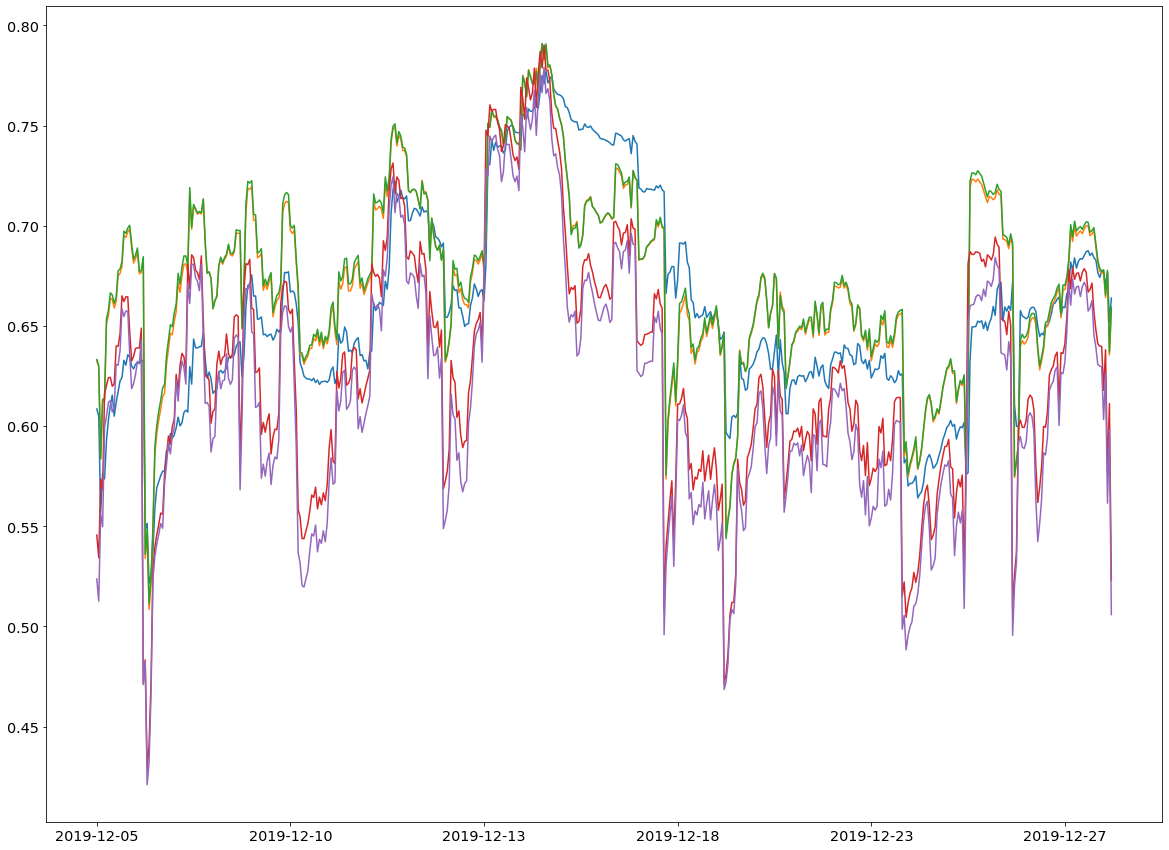

In [246]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

plt.plot(dcc11_results['cor(EEM,SPY)'].values, label='dcc11')
plt.plot(dcc_opt_results['cor(EEM,SPY)'].values, label='dcc_opt')
plt.plot(dcc_opt_a_results['cor(EEM,SPY)'].values, label='dcc_opt_a')
plt.plot(simulation_predictions1['cor(EEM,SPY)'].values, label='simulation_predictions1')
plt.plot(simulation_predictions2['cor(EEM,SPY)'].values, label='simulation_predictions2')

ax.set_xticklabels(x_values[[0,3,6,9,12,15,18,-1]])
#plt.legend(prop={'size': 20})
plt.savefig(os.path.join(results_path, 'eem_spy_corr.png'), dpi=400, facecolor='aliceblue',edgecolor='k',bbox_inches='tight')
plt.show()

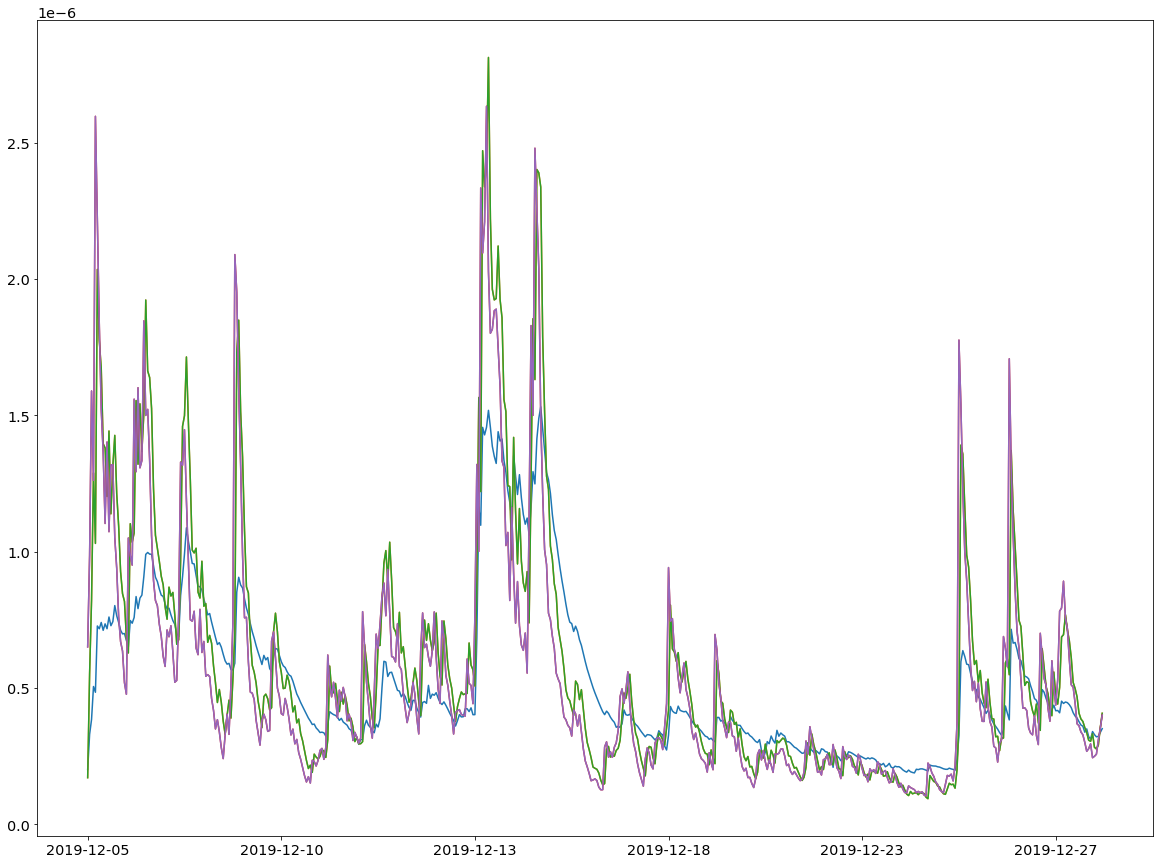

In [247]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

plt.plot(dcc11_results.varSPY.values, label='dcc11')
plt.plot(dcc_opt_results.varSPY.values, label='dcc_opt')
plt.plot(dcc_opt_a_results.varSPY.values, label='dcc_opt_a')
plt.plot(simulation_predictions1.varSPY.values, label='simulation_predictions1')
plt.plot(simulation_predictions2.varSPY.values, label='simulation_predictions2')
#plt.plot(RV.varSPY.values, color='lime', label='RV')

ax.set_xticklabels(x_values[[0,3,6,9,12,15,18,-1]])
#plt.legend(prop={'size': 20})
plt.savefig(os.path.join(results_path, 'predictited_var_spy.png'), dpi=400, facecolor='aliceblue',edgecolor='k',bbox_inches='tight')
plt.show()

# DMW Test

In [164]:
def create_matrix(df):
    res = []
    for i in range(len(df)):
        res.append([[df.iloc[i,0], df.iloc[i,3], df.iloc[i,4]], [df.iloc[i,3], df.iloc[i,1], df.iloc[i,5]], [df.iloc[i,4], df.iloc[i,5], df.iloc[i,2]]])
    return res

In [167]:
rv_series = create_matrix(RV)
dcc11_series = create_matrix(dcc11_results)
dcc_opt_series = create_matrix(dcc_opt_results)
dcc_opt_a_series = create_matrix(dcc_opt_a_results)
simulation1_series = create_matrix(simulation_predictions1)
simulation2_series = create_matrix(simulation_predictions2)

In [186]:
def qlike(forecast, rv):
    return np.log(forecast) + rv/forecast

def qlike_matrix(forecast_matrix, rv_matrix):
    return np.mean(np.log(forecast_matrix) + np.divide(rv_matrix , forecast_matrix))
    
def dt_comp(forecast1, forecast2, rv_matrix):
    L1 = qlike_matrix(forecast1, rv_matrix)
    L2 = qlike_matrix(forecast2, rv_matrix)
    return L1 - L2

In [187]:
from scipy.stats import norm
def DMW(forecast_series1, forecast_series2, rv_series):
    dt_series = [dt_comp(forecast1, forecast2, rv_matrix) for forecast1, forecast2, rv_matrix 
                 in zip(forecast_series1, forecast_series2, rv_series)]
    T = len(dt_series)
    test_stat = np.sqrt(T) * np.mean(dt_series) / np.std(dt_series)
    pval = 1 - norm.cdf(test_stat)
    return test_stat, pval

In [224]:
series_names = ['DCC(1,1) sGARCH', 'DCC(1,1) Opt.', 'aDCC (1,1) Opt.', 'Copula(1,1) Opt.', 'Copula(1,1) Opt. Norm.']
series = [dcc11_series, dcc_opt_series, dcc_opt_a_series, simulation1_series, simulation2_series]
dmw_data = np.empty((len(series),len(series)))
dmw_data_pval = np.empty((len(series),len(series)))
for i in range(len(series)):
    for j in range(len(series)):
        dmw_data[i,j] = DMW(series[i], series[j], rv_series)[0]
        dmw_data_pval[i,j] = DMW(series[i], series[j], rv_series)[1]

In [225]:
dmw_data = pd.DataFrame(dmw_data, columns=series_names, index=series_names)
dmw_data

,"DCC(1,1) sGARCH","DCC(1,1) Opt.","aDCC (1,1) Opt.","Copula(1,1) Opt.","Copula(1,1) Opt. Norm."
"DCC(1,1) sGARCH",NaN,1.567666,1.530492,5.577840,5.686627
"DCC(1,1) Opt.",-1.567666,NaN,-6.826363,4.982182,5.133712
"aDCC (1,1) Opt.",-1.530492,6.826363,NaN,5.019727,5.171195
"Copula(1,1) Opt.",-5.577840,-4.982182,-5.019727,NaN,3.417375
"Copula(1,1) Opt. Norm.",-5.686627,-5.133712,-5.171195,-3.417375,NaN


In [226]:
def pval_fc(val):
    if val <= 0.01:
        return '***'
    elif val <= 0.05:
        return '**'
    elif val <= 0.1:
        return '*'
    else:
        return '0'

In [227]:
dmw_data_pval = pd.DataFrame(dmw_data_pval, columns=series_names, index=series_names).applymap(pval_fc)
dmw_data_pval

,"DCC(1,1) sGARCH","DCC(1,1) Opt.","aDCC (1,1) Opt.","Copula(1,1) Opt.","Copula(1,1) Opt. Norm."
"DCC(1,1) sGARCH",0,*,*,***,***
"DCC(1,1) Opt.",0,0,0,***,***
"aDCC (1,1) Opt.",0,***,0,***,***
"Copula(1,1) Opt.",0,0,0,0,***
"Copula(1,1) Opt. Norm.",0,0,0,0,0
